# Setup

In [1]:
# Python 3 compatability
from __future__ import division, print_function

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
import scipy
from scipy import stats

# plotting
import matplotlib
from matplotlib import pyplot as plt

# fits data
from astropy.io import fits

# inline plotting
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Catalog Stacking with SDSS Stripe 82

Plot comparisons of catalog-level stacks using data from SDSS Stripe 82.

In [3]:
# convert from fluxes to magnitudes
def magnitude(phot, err, zeropoints=1.):

    mag = -2.5 * np.log10(phot / zeropoints)
    mag_err = 2.5 / np.log(10.) * err / phot

    return mag, mag_err

# convert from magnitudes to fluxes
def inv_magnitude(mag, err, zeropoints=1.):
    
    phot = 10**(-0.4 * mag) * zeropoints
    phot_err = err * 0.4 * np.log(10.) * phot
    
    return phot, phot_err

In [4]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# load data
s82_stack = fits.open('data/s82/s82.fits')[1].data
s82_runs = fits.open('data/s82/dr14.fits')[1].data

# stacked data
ra, dec = s82_stack['ra'], s82_stack['dec']
mtrue, metrue = s82_stack['psfcounts'], s82_stack['psfcountserr']
ftrue, fetrue = inv_magnitude(mtrue, metrue, zeropoints=1e9)
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)

# individual run data
ra2, dec2 = s82_runs['ra'], s82_runs['dec']
fobs, feobs = s82_runs['psfflux'], s82_runs['psfflux_ivar']**-0.5
mobs, meobs = magnitude(fobs, feobs, zeropoints=1e9)
c2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)

# sort runs by FWHM
runs = np.unique(s82_runs['run'])  # individual runs
fwhm = np.array([np.median(s82_runs['psf_fwhm'][s82_runs['run'] == run], 
                           axis=0)  # median FWHM in each band
                 for run in runs])  # over each run
sort_idx = np.argsort(fwhm, axis=0)
runs_sorted = runs[sort_idx]
fwhm_sorted = np.array([fwhm[sort_idx[:, i], i] for i in range(5)]).T

# match catalogs
match_idx, d2d, _ = c2.match_to_catalog_sky(c)
match_sel = d2d.arcsec < 0.5

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [5]:
# find how many runs an object was observed over
uidx, nruns = np.unique(match_idx[match_sel], return_counts=True)

# select objects observed repeatedly
max_stacks, buffer = 10, 1
sel = nruns >= max_stacks + buffer
uidx, nruns = uidx[sel], nruns[sel]

# flag objects which have too many unreliable observations
mo, moe = mobs[match_sel], meobs[match_sel]
midx = match_idx[match_sel]
m, me = mtrue[midx], metrue[midx]
clean = ((mo < 30.) & np.isfinite(mo) & np.isfinite(moe) &
         (m < 22.9) & np.isfinite(m) & np.isfinite(me) &
         (s82_stack['objc_prob_psf'][midx] > 0.99)[:, None] & 
         (np.abs(m - mo) < 2.))
print(len(uidx))

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


218439


/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [6]:
np.random.seed(62064)

# compute weighted magnitude averages for different sets of runs
stacks = np.array([1, 3, 5, 7, 10])
mavg = np.zeros((len(uidx), 5, len(stacks))) + np.nan
merr = np.zeros((len(uidx), 5, len(stacks))) + np.nan
m_base, me_base = np.zeros((len(uidx), 5)) + np.nan, np.zeros((len(uidx), 5)) + np.nan

flux, fluxerr = inv_magnitude(mo, np.sqrt(moe**2 + 0.01**2))
for count, u in enumerate(uidx):
    usel = np.where(midx == u)[0]  # select object
    for b in range(5):
        uclean = clean[usel, b]
        usel_clean = usel[uclean]  # subselect only clean observations
        if len(usel_clean) >= max_stacks:
            m_base[count, b], me_base[count, b] = m[usel[0], b], me[usel[0], b]
            # pick `max_stacks` observations at random
            usel_rsamp = np.random.choice(usel_clean, size=max_stacks, replace=False)
            # compute weighted average in *flux*
            for i, s in enumerate(stacks):
                usel_t = usel_rsamp[:s]
                favg = np.average(flux[usel_t, b], weights=fluxerr[usel_t, b]**-2)
                ferr = np.sqrt(np.sum(fluxerr[usel_t, b]**-2)**-1)
                mavg[count, b, i], merr[count, b, i] = magnitude(favg, ferr)
    # print progress
    if (count + 1) % 100 == 0:
        sys.stderr.write('\r {}/{}'.format(count + 1, len(uidx)))

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
 218400/218439

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater


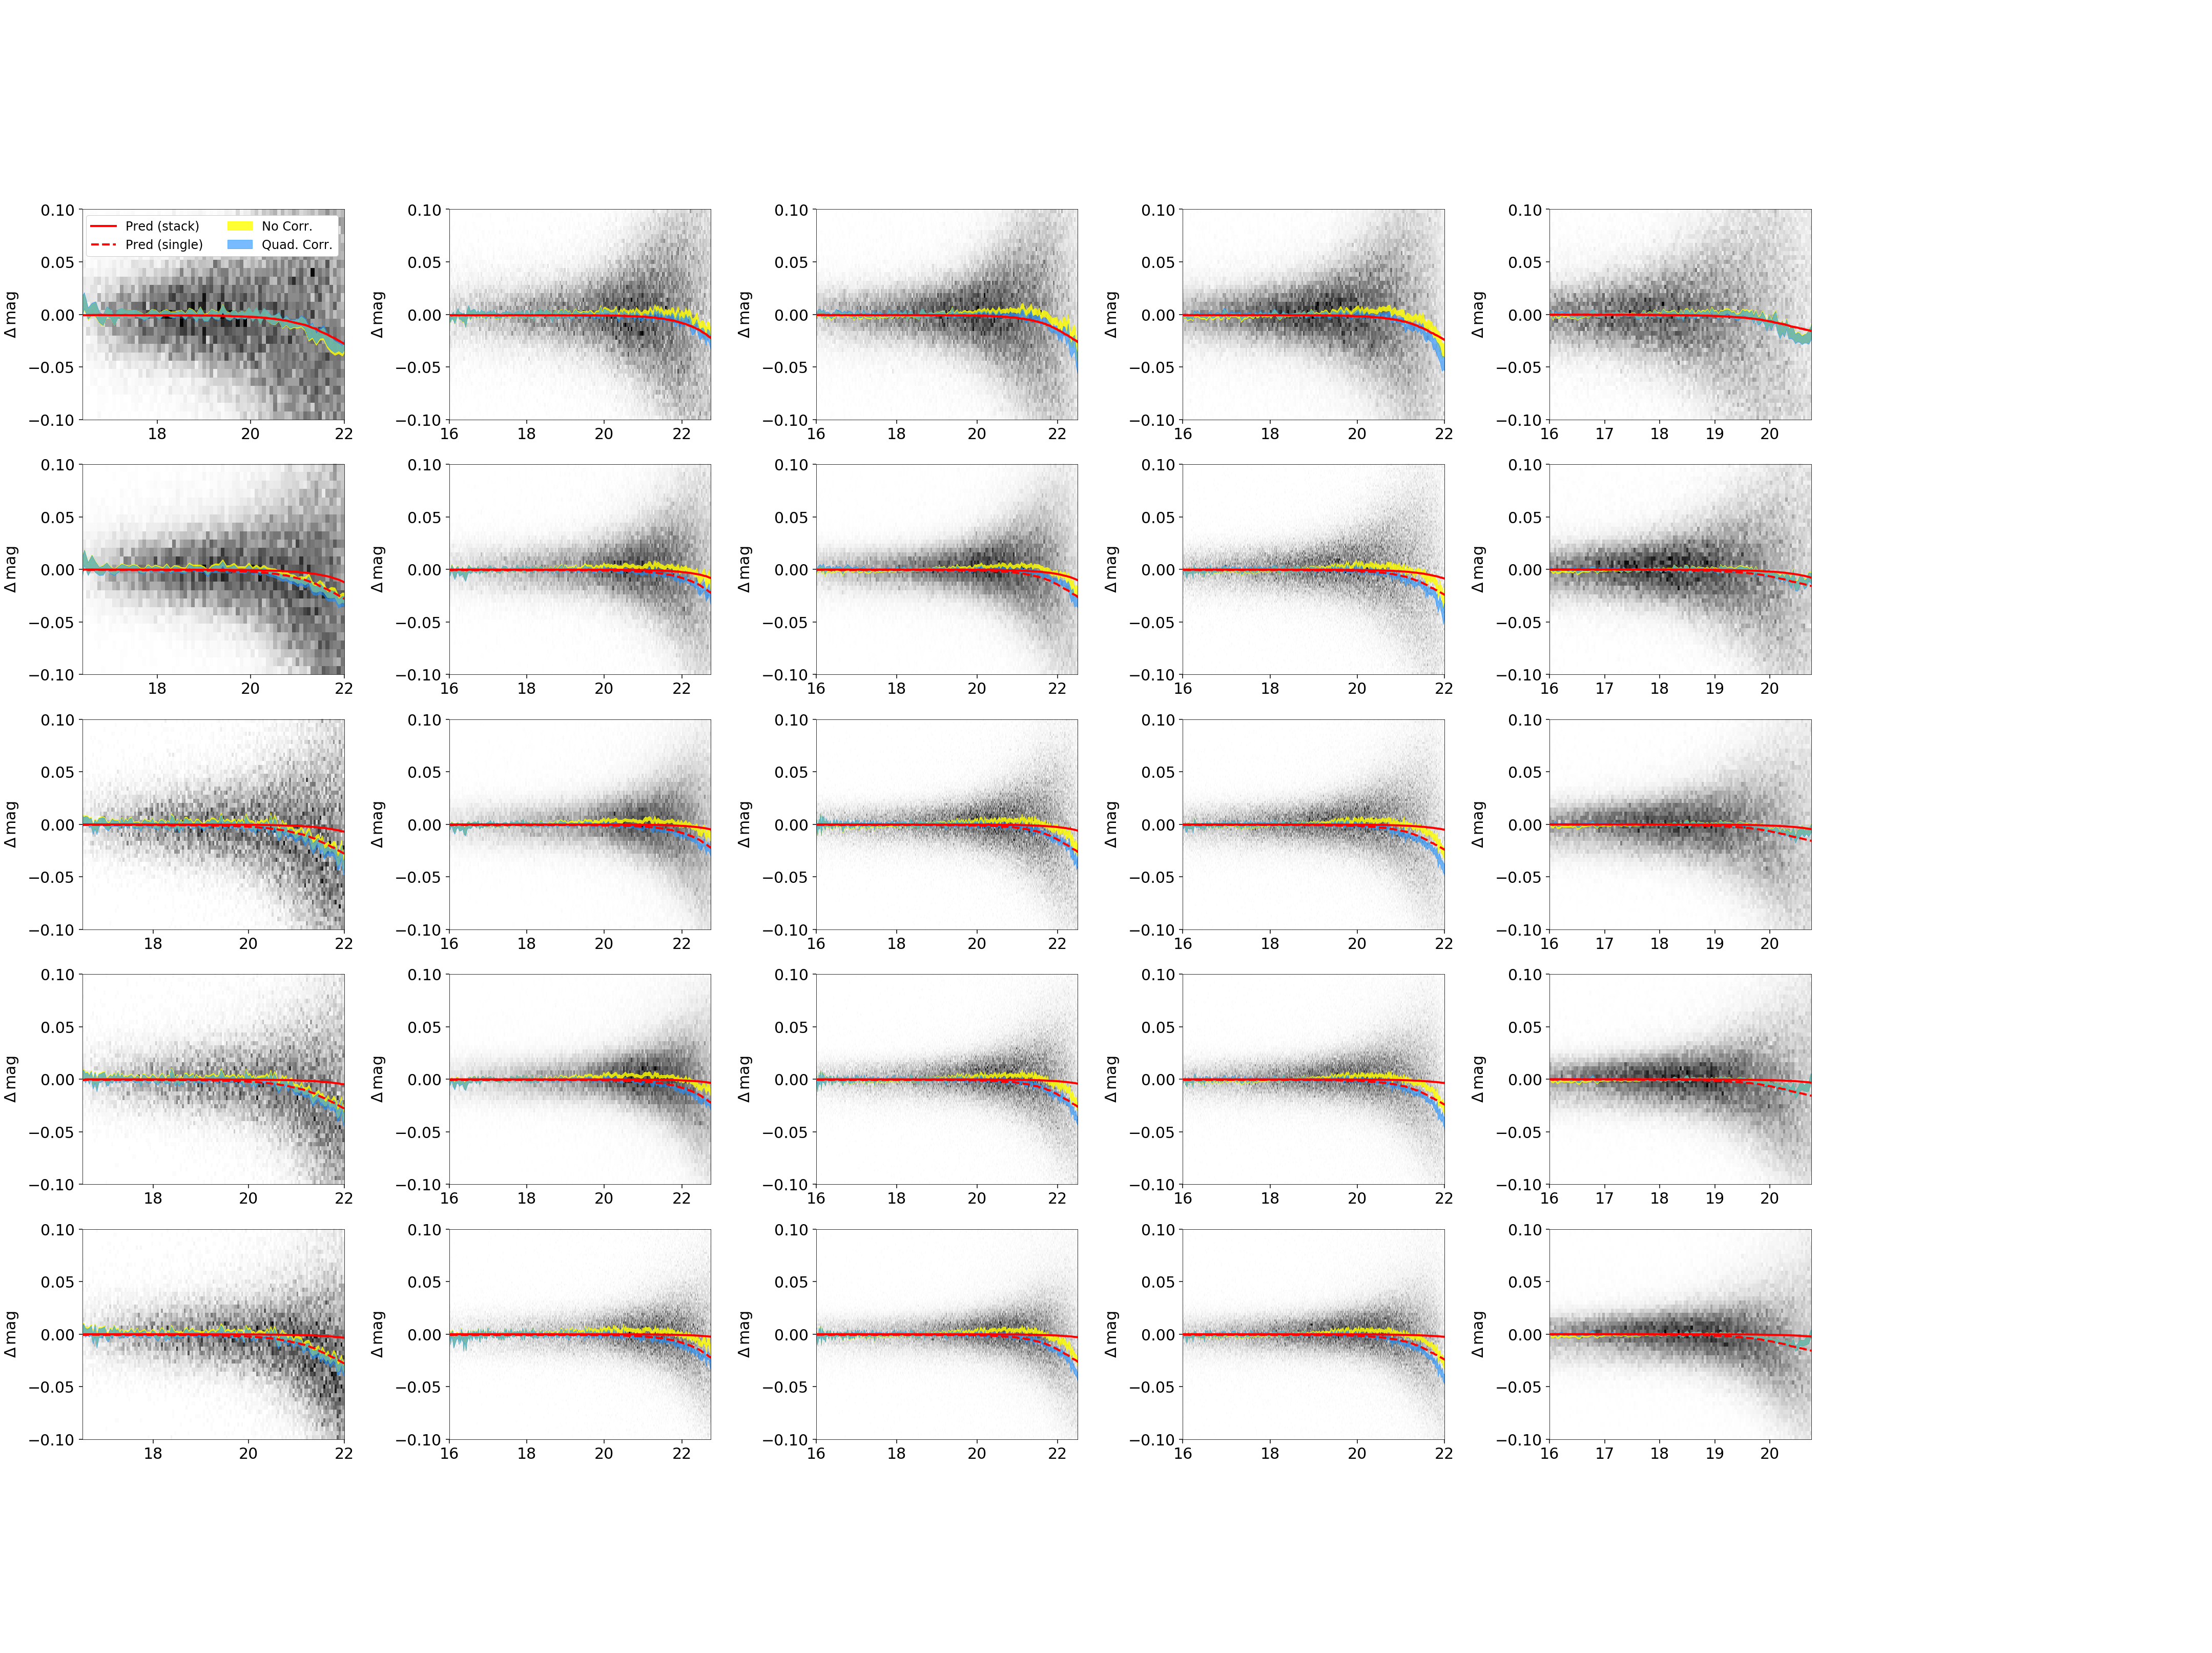

In [24]:
bands = ['U', 'G', 'R', 'I', 'Z']
cpivot, mrange = 1e-4, 2.  # pivot point & mag range used to shift offsets
boxcar = 6  # bins used for boxcar used to determine variance for plotting
mgrid = np.arange(16, 28., 1e-2)  # magnitude bins
dmgrid = np.arange(-0.3, 0.3, 1e-3)  # dmag bins
dmpgrid = np.arange(-0.05, 0.05, 1e-5)  # dmag (predicted) bins
fbins = 0.2  # fraction of occupied bins above threshold
nmin = 10  # minimum number of objects required to plot results

# plot results per band
rows = len(stacks)
plt.figure(figsize=(50, 7 * rows))
for i in range(5):
    for j, _ in enumerate(stacks):
        mo, moe = mavg[:, i, j], merr[:, i, j]
        m, me = m_base[:, i], me_base[:, i]
        # clean
        clean = (np.isfinite(m) & np.isfinite(me) & 
                 np.isfinite(mo) & np.isfinite(moe))
        mo, moe, m, me = mo[clean], moe[clean], m[clean], me[clean]
        moff = np.median((m - mo)[(m > 17.) & (m < 19.)])
        
        # determine spacing
        mgrid_t, dmgrid_t = np.array(mgrid), np.array(dmgrid)  # temp grids
        while True:
            n, bx, by = np.histogram2d(m, mo - m + moff, [mgrid_t, dmgrid_t])
            # lower resolution if we don't have enough bins with enough counts
            if np.sum(n > nmin) / np.sum(n > 0) < fbins:
                mgrid_t, dmgrid_t = mgrid_t[::2], dmgrid_t[::2]
            else:
                break

        # dmag distribution (shifted)
        plt.subplot(rows, 5, i + 5*j + 1)
        n, bx, by, _ = plt.hist2d(m, mo - m + moff, [mgrid_t, dmgrid_t], 
                                  cmap='Greys', zorder=1)
        xc, yc = 0.5 * (bx[1:] + bx[:-1]), 0.5 * (by[1:] + by[:-1])  # bin centers
        nmag = np.sum(n, axis=1)  # counts per magnitude bin
        nmean = np.sum(yc * n, axis=1) / np.sum(n, axis=1)  # mean
        nstd = np.sqrt(np.sum((yc[None, :] - nmean[:, None])**2 * n,
                              axis=1) / np.sum(n, axis=1))  # error
        nidx = np.where(n.sum(axis=1) > nmin * 5)[0][0]
        nidx2 = np.where(n.sum(axis=1) > nmin * 5)[0][-1]

        # compute SNR as a function of magnitude
        mconst = 2.5 / np.log(10)
        fout, fe = inv_magnitude(mo, moe)
        fin, fe2 = inv_magnitude(m, me)
        snr = fout/np.sqrt(fe**2 + (0.01 * fout)**2)
        # first order
        n, bx, by = np.histogram2d(m, -mconst * snr**-2,
                                   [mgrid_t, dmpgrid])
        xc, yc = 0.5 * (bx[1:] + bx[:-1]), 0.5 * (by[1:] + by[:-1])
        cmean = np.sum(yc * n, axis=1) / np.sum(n, axis=1)
        if i == 4:
            cmean /= 2  # Y-band errors appear overestimated

        # prettify
        plt.ylabel(r'$\Delta\,$mag')
        try:
            midx = np.where(cmean < -0.03)[0][0]
        except:
            midx = nidx2
            pass
        if i == 0:
            plt.xlim([mgrid_t[nidx], 22])
        elif i == 1:
            plt.xlim([mgrid_t[nidx], 22.75])
        elif i == 2:
            plt.xlim([mgrid_t[nidx], 22.5])
        elif i == 3:
            plt.xlim([mgrid_t[nidx], 22])
        elif i == 4:
            plt.xlim([mgrid_t[nidx], 20.75])
        plt.ylim([-0.1, 0.1])
        plt.tight_layout()

        # plot bias
        mhigh = xc[np.abs(cmean - np.nanmax(np.abs(cmean))) > cpivot][0]
        mlow = mhigh - mrange
        nsel = nmag > nmin
        nmean_err = nstd/np.sqrt(nmag)
        nmean_serr = np.array([np.std(nmean[i:i+boxcar]) for i in range(len(nmean) - boxcar)])
        nmean_err[boxcar//2:-boxcar//2] = np.sqrt(nmean_err[boxcar//2:-boxcar//2]**2 + nmean_serr**2)
        plt.fill_between(xc[nsel], (nmean - nmean_err)[nsel],
                         (nmean + nmean_err)[nsel], color='yellow', alpha=0.8, zorder=2)
        # apply linear bias correction
        if i < 4:
            # UGRI
            lin_coeff = np.polyfit(xc[(xc >= 17) & (xc <= 20) & nsel], 
                                   nmean[(xc >= 17) & (xc <= 20) & nsel], 2)
        else:
            # Z
            lin_coeff = np.polyfit(xc[(xc >= 16) & (xc <= 19.5) & nsel], 
                                   nmean[(xc >= 16) & (xc <= 19.5) & nsel], 2)
        lin_off = np.poly1d(lin_coeff)(xc)
        nmean -= lin_off
        plt.fill_between(xc[nsel], (nmean - nmean_err)[nsel],
                         (nmean + nmean_err)[nsel], color='dodgerblue', alpha=0.6, zorder=2)
        # plot prediction
        plt.plot(xc[nsel], cmean[nsel], lw=4, color='red', zorder=3)
        if j == 0:
            xc_true, cmean_true = xc[nsel], cmean[nsel]
        plt.plot(xc_true, cmean_true, lw=4, color='red', zorder=3, ls='dashed')

        # legend
        if i == 0 and j == 0:
            plt.legend(['Pred (stack)', 'Pred (single)', 'No Corr.', 'Quad. Corr.'], 
                       framealpha=1., ncol=2, fontsize=24)
            
# save figure
#plt.savefig('plots/s82_catstack.png'.format(bands[i]), bbox_inches='tight')